In [119]:
from pathlib import Path
from tensorflow.python.keras.callbacks import EarlyStopping
%matplotlib inline
import pandas as pd
from imutils import build_montages
import numpy as np
import cv2
from tqdm.notebook import tqdm
from pprint import pprint
import os
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import skimage
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, GlobalAveragePooling2D, MaxPooling2D, Lambda

In [120]:
physical_devices = tf.config.list_physical_devices('GPU')
for gpu in physical_devices:
    tf.config.experimental.set_memory_growth(gpu, True)
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# load/preprocess images

In [121]:
DATA_DIR = Path('./frgc32x32/')
images = [x.name for x in DATA_DIR.glob('*')]

In [122]:
image_paths = list(DATA_DIR.glob('*.png'))
user_id = [x.name.split('d')[0] for x in image_paths]
user_img_id = [x.name.split('d')[1].replace('.png', '') for x in image_paths]

directory_df = pd.DataFrame({
    'user_id': user_id,
    'user_img_id': user_img_id,
    'path': [str(x) for x in image_paths]
})

In [123]:
(    directory_df
    .groupby('user_id')['user_img_id']
    .count()
    .to_frame('count')
    .sort_values('count')
     .describe()
)

,count
count,568.000000
mean,21.667254
std,16.794857
min,2.000000
25%,8.000000
50%,18.000000
75%,32.000000
max,70.000000


<AxesSubplot:xlabel='user_id'>

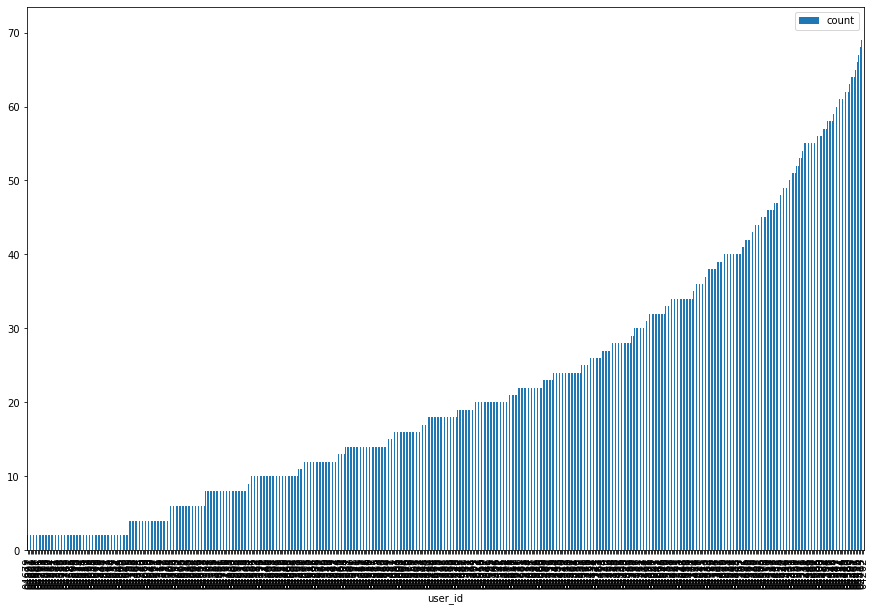

In [124]:
(
    directory_df
    .groupby('user_id')['user_img_id']
    .count()
    .to_frame('count')
    .sort_values('count')
    .plot(kind='bar', figsize=(15, 10))
)

In [125]:
# Get all classes from 10 samples till 60 samples
data_size = 20
class_count_required = 60

ids_testing = ( 
    directory_df
    .groupby('user_id')['user_img_id']
    .count() < data_size
)

ids_to_keep = ( 
    directory_df
    .groupby('user_id')['user_img_id']
    .count() >= data_size
)

ids_to_keep = ids_to_keep[ids_to_keep].index
ids_test = ids_testing[ids_testing].index

subset_directory_df = (
    directory_df
    .loc[directory_df['user_id'].isin(ids_to_keep)]
    .sample(frac=1)
    .groupby('user_id')
    .head(class_count_required)
    .copy()
)

test_df = (
    directory_df
    .loc[directory_df['user_id'].isin(ids_test)]
    .sample(frac=1)
    .copy()
)

old_unique = directory_df['user_id'].nunique()
new_unique = subset_directory_df['user_id'].nunique()
print(f"There are {new_unique}/{old_unique} ({new_unique/old_unique*100:.2f}%)" +
      " unique IDs remaining.")

test_unique = test_df['user_id'].nunique()
print(f"There are {test_unique} IDS for testing")

There are 265/568 (46.65%) unique IDs remaining.
There are 303 IDS for testing


<AxesSubplot:xlabel='user_id'>

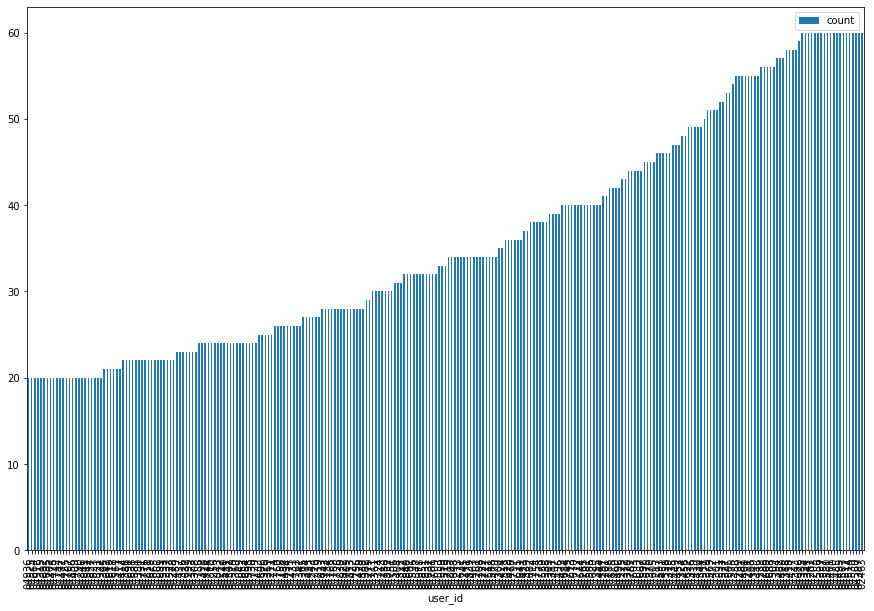

In [126]:
(
    subset_directory_df
    .groupby('user_id')['user_img_id']
    .count()
    .to_frame('count')
    .sort_values('count')
    .plot(kind='bar', figsize=(15, 10))
)

In [127]:
counts = (
    subset_directory_df
    .groupby('user_id')['user_img_id']
    .count()
    .to_frame('count')
    .sort_values('count')
    .reset_index(drop=False)
    .assign(augmentation_needed=lambda 
            df: class_count_required-df['count'])
)

In [128]:
counts.head()

,user_id,count,augmentation_needed
0,04936,20,40
1,04525,20,40
2,04664,20,40
3,04916,20,40
4,04315,20,40


In [129]:
counts_test = (
    test_df
    .groupby('user_id')['user_img_id']
    .count()
    .to_frame('count')
    .sort_values('count')
    .reset_index(drop=False)
    .assign(augmentation_needed=lambda 
            df: class_count_required-df['count'])
)
counts_test['augmentation_needed'] = 0

In [130]:
counts_test.head()

,user_id,count,augmentation_needed
0,04200,2,0
1,04845,2,0
2,04858,2,0
3,04623,2,0
4,04860,2,0


In [131]:
subset_directory_df.head()
subset_directory_df_sorted = (
    subset_directory_df.sort_values(by=['path'])
)
test_df_sorted = test_df.sort_values(by=['path'])

In [132]:
from imgaug import augmenters as iaa

def augment_image(image):
    # https://github.com/aleju/imgaug
    augmentations = iaa.Sequential([
        iaa.SaltAndPepper(0.03),
    #     iaa.AdditiveGaussianNoise(scale=(0, 0.2*255)),
    #     iaa.AdditiveLaplaceNoise(scale=(0, 0.03*255)),
    #     iaa.CoarseDropout((0.01, 0.04), size_percent=(0.02, 0.18))
    ])
    seq = augmentations
    return seq(image=image)

In [133]:
from tqdm import tqdm

def read_image(file_path, augment=False):
    img = cv2.imread(file_path, 0)
    img = cv2.resize(img, (32, 32))
    if augment:
        img = augment_image(img)
    return img

In [134]:
def load_images_augment(dataframe, augment_df):
    _labels = []

    items = []
    for _, row in tqdm(augment_df.iterrows(), total=augment_df.shape[0]):
        user_id = row['user_id']
        augmentation_needed = row['augmentation_needed']
        
        _labels.append(user_id)
        lbl = _labels.index(user_id)
        
        relevant_subset = dataframe.loc[dataframe['user_id']==user_id].copy()
        
        for _, row in relevant_subset.iterrows():
            img = read_image(row['path'], augment=False)
            items.append((img, lbl))
            
        if augmentation_needed > relevant_subset.shape[0]:
            items_to_augment = relevant_subset.sample(augmentation_needed, replace=True)    
        else:
            items_to_augment = relevant_subset.sample(augmentation_needed)
        
        for _, row in items_to_augment.iterrows():
            img = read_image(row['path'], augment=True)
            items.append((img, lbl))
    return items

In [135]:
items = load_images_augment(subset_directory_df_sorted, counts)

assert len(items) == counts.shape[0] * class_count_required

100%|██████████| 265/265 [00:07<00:00, 36.36it/s]


In [136]:
test_items = load_images_augment(test_df_sorted, counts_test)

100%|██████████| 303/303 [00:00<00:00, 346.28it/s]


In [137]:
def make_pairs(images, labels, num_classes):
    pairImages = []
    pairLabels = []

    idx = [np.where(labels == i)[0] for i in range(0, num_classes)]

    for idxA in tqdm(range(len(images))):
        currentImage = images[idxA]
        label = labels[idxA]
        idxB = np.random.choice(idx[label])
        posImage = images[idxB]

        pairImages.append([currentImage, posImage])
        pairLabels.append([1])

        negIdx = np.where(labels != label)[0]
        negImage = images[np.random.choice(negIdx)]

        pairImages.append([currentImage, negImage])
        pairLabels.append([0])

    return np.array(pairImages), np.array(pairLabels)

In [138]:
train_test_split = 0.7
split = int(train_test_split * new_unique) * class_count_required

with open ('identities.txt', 'w+') as f:
    f.write(', '.join([img for img in subset_directory_df_sorted['path'][:split]]) + '\n')
    f.write(', '.join([img for img in subset_directory_df_sorted['path'][split:]]) + '\n')

trainX = np.array([x[0] for x in items[:split]])
trainY = np.array([x[1] for x in items[:split]])

valX = np.array([x[0] for x in items[split:]])
valY = np.array([x[1] for x in items[split:]])

testX = np.array([x[0] for x in test_items])
testY = np.array([x[1] for x in test_items])

trainX = trainX / 255.0
valX = valX / 255.0
testX = testX / 255.0

# add a channel dimension to the images
trainX = np.expand_dims(trainX, axis=-1)
valX = np.expand_dims(valX, axis=-1)
testX = np.expand_dims(testX, axis=-1)

(pairTrain, labelTrain) = make_pairs(trainX, trainY, num_classes=new_unique)
(pairVal, labelVal) = make_pairs(valX, valY, num_classes=new_unique)
(pairTest, labelTest) = make_pairs(testX, testY, num_classes=test_unique)

100%|██████████| 2759/2759 [00:00<00:00, 70701.17it/s]



# build model

In [139]:
IMG_SHAPE = (32, 32, 1)
BATCH_SIZE = 64
EPOCHS = 500

In [140]:
def build_model_20(inputShape, embeddingDim=48):
    inputs = Input(inputShape)
    x = Conv2D(48, (3, 3), padding="same", activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(48, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    pooledOutput = GlobalAveragePooling2D()(x)
    outputs = Dense(embeddingDim)(pooledOutput)

    model = Model(inputs, outputs, name = 'model_20')

    return model


In [141]:
def build_model_60(inputShape, embeddingDim=48):
    inputs = Input(inputShape)
    x = Conv2D(64, (3, 3), padding="same", activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(48, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    pooledOutput = GlobalAveragePooling2D()(x)
    outputs = Dense(embeddingDim)(pooledOutput)

    model = Model(inputs, outputs, name = 'model_60')

    return model

In [142]:
def build_model_130(inputShape, embeddingDim=48):
    inputs = Input(inputShape)
    x = Conv2D(128, (5, 5), padding="same", activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(80, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(48, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    pooledOutput = GlobalAveragePooling2D()(x)
    outputs = Dense(embeddingDim)(pooledOutput)

    model = Model(inputs, outputs, name = 'model_130')

    return model

In [143]:
def build_model_250(inputShape, embeddingDim=48):
    inputs = Input(inputShape)
    x = Conv2D(128, (5, 5), padding="same", activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(96, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(96, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    pooledOutput = GlobalAveragePooling2D()(x)
    outputs = Dense(embeddingDim)(pooledOutput)

    model = Model(inputs, outputs, name = 'model_250')

    return model

In [144]:
def euclidean_distance(vectors):
	# unpack the vectors into separate lists
    featsA = vectors[0]
    featsB = vectors[1]
	# compute the sum of squared distances between the vectors
    sumSquared = K.sum(K.square(featsA - featsB), axis=1,
        keepdims=True)
	# return the euclidean distance between the vectors
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))

def plot_training(H, plotPath):
    # construct a plot that plots and saves the training history
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(H.history["loss"], label="train_loss")
    plt.plot(H.history["val_loss"], label="val_loss")
    plt.plot(H.history["accuracy"], label="train_acc")
    plt.plot(H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig(plotPath)

In [145]:
import datetime
from pathlib import Path
from tensorflow.keras.callbacks import EarlyStopping

def train_model(model_fun, save_name, train = True):
    print(f'Training model: {save_name}')
    
    log_dir = "tensor_logs/" + save_name + '_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

    base_out = Path('models')
    model_path = base_out / f'model_{save_name}_temp'
    model_path.mkdir(parents=True, exist_ok=True)
    plot_path = base_out / f'plot_{save_name}.png'

    imgA = Input(shape=IMG_SHAPE)
    imgB = Input(shape=IMG_SHAPE)
    featureExtractor = model_fun(IMG_SHAPE)
    featsA = featureExtractor(imgA)
    featsB = featureExtractor(imgB)

    distance = Lambda(euclidean_distance)([featsA, featsB])
    outputs = Dense(1, activation="sigmoid")(distance)
    model = Model(inputs=[imgA, imgB], outputs=outputs)

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])


    if not train:
        return
    
    early_stopping = EarlyStopping(mode='min', patience=5, verbose=1)
    
    history = model.fit(
        [pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
        validation_data=([pairVal[:, 0], pairVal[:, 1]], labelVal[:]),
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[tensorboard_callback, early_stopping])

    model.save(str(model_path))
#     plot_training(history, plot_path)
    return model

# Train

In [146]:
train = True
model20 = train_model(build_model_20, 'sn_20', train)
model60 = train_model(build_model_60, 'sn_60', train)
model130 = train_model(build_model_130, 'sn_130', train)
model250 =train_model(build_model_250, 'sn_250', train)

Training model: sn_250
Epoch 1/500
347/347 [==============================] - 7s 19ms/step - loss: 0.6939 - accuracy: 0.5030 - val_loss: 0.6647 - val_accuracy: 0.5741

# Final step: Testing + Comparing our models

In [147]:
model_20_test = model20.evaluate([pairTest[:, 0], pairTest[:, 1]], labelTest[:])

model_60_test = model60.evaluate([pairTest[:, 0], pairTest[:, 1]], labelTest[:])

model_130_test = model130.evaluate([pairTest[:, 0], pairTest[:, 1]], labelTest[:])

model_250_test = model250.evaluate([pairTest[:, 0], pairTest[:, 1]], labelTest[:])

173/173 [==============================] - 1s 5ms/step - loss: 0.3023 - accuracy: 0.8686

In [148]:
print("Model 20:")
print(f"Test loss: {model_20_test[0]:.3f} | Test accuracy {model_20_test[1]}")
print("Model 60:")
print(f"Test loss: {model_60_test[0]:.3f} | Test accuracy {model_60_test[1]}")
print("Model 130:")
print(f"Test loss: {model_130_test[0]:.3f} | Test accuracy {model_130_test[1]}")
print("Model 250:")
print(f"Test loss: {model_250_test[0]:.3f} | Test accuracy {model_250_test[1]}")

Model 20:
Model 60:
Model 130:
Model 250:
Test loss: 0.302 | Test accuracy 0.8686118125915527


terminal command for displaying the board: tensorboard --logdir=./tensor_logs